# Ch3 Pytorch 模块与基础实战

## 深度学习在实现上的特殊性

- 样本量大，通常需要分批(batch)加载
- 神经网络有很多层，搭建的时候是逐层、模块化搭建网络（卷积层、全连接层、LSTM等）
- 多样化的损失函数和优化器设计  
    - 机器学习也有
- GPU的使用
    - 并行计算
- 以上各个模块之间的配合

## Pytorch 深度学习模块
- 将Pytorch完成深度学习的步骤拆解为几个主要的模块 --> 搭积木

以FashionMNIST时装分类进行演示

这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集（https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion ）。上图给出了FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为32*32pixel，分属10个类别。

### 基本配置

首先导入必要的包

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

配置训练环境和超参数

In [2]:
torch.cuda.is_available()

True

In [3]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'    # 在当前的程序下，pytorch读取'CUDA_VISIBLE_DEVICES'，第‘0’块显卡（物理上的第一块显卡）


# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256   # 每次读入数据的大小
num_workers = 4    # 有多少个线程可以用   #对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4          # initial learning rate
epochs = 20        # 训练多少轮

### 数据读入和加载
这里同时展示两种方式:

    - 下载并使用PyTorch提供的内置数据集
    - 从网站下载以csv格式存储的数据，读入并转成预期的格式
    第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）
    第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要

同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。

这些变换可以很方便地借助torchvision包来完成，这是PyTorch官方用于图像处理的工具库，上面提到的使用内置数据集的方式也要用到。PyTorch的一大方便之处就在于它是一整套“生态”，有着官方和第三方各个领域的支持。这些内容我们会在后续课程中详细介绍。



时装数据是图片，csv是很不友好的，需要转化成为想要的数据类型

In [4]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28   # 为了和模型进行匹配,可以改成任何模型，但是要匹配
data_transform = transforms.Compose([
    transforms.ToPILImage(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])


In [5]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets 

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)  # train=True, 训练集
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)  # train=False, 测试集



In [6]:
## 读取方式二：读入csv格式的数据，自行构建Dataset类
# csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):  # FMDataset 是 Dataset的一个子类
    def __init__(self, df, transform=None):  
        self.df = df   # train_df
        self.transform = transform   # 实现的变化是什么
        # 怎么读数据，转为图片？
        # 得到所有信息
        self.images = df.iloc[:,1:].values.astype(np.uint8)  # 所有行，但是不包括第0列-->label # unit8是图片格式
        self.labels = df.iloc[:, 0].values   # 所有行，第0列
        
    def __len__(self):
        return len(self.images)   
    
    def __getitem__(self, idx):
        # idx 是 index
        # 在__init__得到的是所有信息, self.images, self.labels
        # 而我们每次只想得到一条信息
        
        image = self.images[idx].reshape(28,28,1)  # 得到第idx个信息  # reshape 成 28*28的图，1是单一通道
        label = int(self.labels[idx])  # 到第idx个label
        if self.transform is not None:
            image = self.transform(image)   
        else:
            image = torch.tensor(image/255., dtype=torch.float)  # 数字转成 0-1,方便模型处理，
        label = torch.tensor(label, dtype=torch.long)
        return image, label   # 每一条数据包含一个imafe,一条label

train_df = pd.read_csv("./FashionMNIST/fashion-mnist_train.csv")
test_df = pd.read_csv("./FashionMNIST/fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)  # 实例化 训练集
test_data = FMDataset(test_df, data_transform)    # 实例化 测试集



In [7]:
train_df  # 按照像素对应像素点的值给存下来， label是对应的类别

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
?DataLoader
# Args:
#     dataset (Dataset): dataset from which to load the data.
#     batch_size (int, optional): how many samples per batch to load
#         (default: ``1``).
#     shuffle (bool, optional): set to ``True`` to have the data reshuffled
#         at every epoch (default: ``False``).
#     sampler (Sampler or Iterable, optional): defines the strategy to draw
#         samples from the dataset. Can be any ``Iterable`` with ``__len__``
#         implemented. If specified, :attr:`shuffle` must not be specified.
#     batch_sampler (Sampler or Iterable, optional): like :attr:`sampler`, but
#         returns a batch of indices at a time. Mutually exclusive with
#         :attr:`batch_size`, :attr:`shuffle`, :attr:`sampler`,
#         and :attr:`drop_last`.
#     num_workers (int, optional): how many subprocesses to use for data
#         loading. ``0`` means that the data will be loaded in the main process.
#         (default: ``0``)

在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据

In [9]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

torch.Size([256, 1, 28, 28]) torch.Size([256])


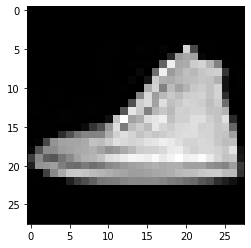

In [10]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))   # iter 迭代，next得到下一个
print(image.shape, label.shape)
plt.imshow(image[100][0], cmap="gray")  

###  模型构建

- 神经网络的构建：基于nn.Module
    - \__init__, forward
- 神经网络是通过“层定义+层顺序” 的方式构建起来的
- 神经网络常见层
    - nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.ReLU, ...

### 模型设计

由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构

模型构建完成后，将模型放到GPU上用于训练



In [11]:
?nn.Conv2d

In [12]:
class Net(nn.Module): # 继承了nn.Module
    def __init__(self):  # 层定义
        super(Net, self).__init__()  
        self.conv = nn.Sequential(        
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )   # 层定义，Sequential 里面已经有顺序了
        # 卷积结束了
        
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),  # 怎么设置都无所谓
            nn.ReLU(),
            nn.Linear(512, 10)      # 有 10 类, Pytorch 会自动转为one-hot
        )
        
    def forward(self, x):
        # 数据怎么走
        x = self.conv(x)    
        x = x.view(-1, 64*4*4)  # 拉平了，便于全连接层操作
        x = self.fc(x)  
        # x = nn.functional.normalize(x)
        return x

model = Net()  # 实例化
model = model.cuda()  # GPU操作，放到GPU上
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解

### 损失函数
- torch.nn提供了多种预定义的损失函数
- 可以自己定义损失函数
- 根据实际需求选用对应的损失函数
- 损失函数常用操作
    - backward()

使用torch.nn模块自带的CrossEntropy损失

PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss

这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [13]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])  # 给不同类设置权重，对4的训练结果不好，给它加大权重

In [14]:
?nn.CrossEntropyLoss

### 优化器

- torch.optim 提供了多种定义的优化器
- 可以使用自定义的优化器
- 根据实际需求选用对应的损失函数
- 优化器常用操作：
    - step(), zero_grad(), load_state_dict()


In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 训练与评估

各自封装成函数，方便后续调用

关注两者的主要区别：

    - 模型状态设置
        - model.train(), model.eval()
        - 每一个tensor是否可以求导
    - 训练流程：读取、转换、梯度清零、输入、计算损失、反向传播、参数更新
    - 验证流程：读取、转换、输入、计算损失、计算指标
  
    - 是否需要初始化优化器
    - 是否需要将loss传回到网络
    - 是否需要每步更新optimizer

此外，对于测试或验证过程，可以计算分类准确率

In [16]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()  # 把数据放到GPU上
        optimizer.zero_grad()  # 对梯度清零，因为梯度会累加
        output = model(data)
        loss = criterion(output, label)
        loss.backward()  # 反向传播回去
        optimizer.step()  # 优化器更新权重
        train_loss += loss.item()*data.size(0)   # 训练损失的迭加
    train_loss = train_loss/len(train_loader.dataset) 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [17]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad(): # 不做梯度计算
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())   # ground truth label
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)   
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [18]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.665188
Epoch: 1 	Validation Loss: 0.430107, Accuracy: 0.848800
Epoch: 2 	Training Loss: 0.427586
Epoch: 2 	Validation Loss: 0.375745, Accuracy: 0.861800
Epoch: 3 	Training Loss: 0.366057
Epoch: 3 	Validation Loss: 0.323086, Accuracy: 0.886100
Epoch: 4 	Training Loss: 0.330203
Epoch: 4 	Validation Loss: 0.304177, Accuracy: 0.886300
Epoch: 5 	Training Loss: 0.308971
Epoch: 5 	Validation Loss: 0.272212, Accuracy: 0.901500
Epoch: 6 	Training Loss: 0.292396
Epoch: 6 	Validation Loss: 0.260503, Accuracy: 0.904100
Epoch: 7 	Training Loss: 0.275803
Epoch: 7 	Validation Loss: 0.257555, Accuracy: 0.906900
Epoch: 8 	Training Loss: 0.264517
Epoch: 8 	Validation Loss: 0.234096, Accuracy: 0.913700
Epoch: 9 	Training Loss: 0.255150
Epoch: 9 	Validation Loss: 0.233216, Accuracy: 0.914200
Epoch: 10 	Training Loss: 0.239761
Epoch: 10 	Validation Loss: 0.221054, Accuracy: 0.918600
Epoch: 11 	Training Loss: 0.233723
Epoch: 11 	Validation Loss: 0.225824, Accuracy: 0.916900
Epoch:

In [21]:
# 查看显存
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Jul 15 17:28:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  Off |
|  0%   42C    P8    23W / 480W |   1783MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 模型保存

训练完成后，可以使用torch.save保存模型参数或者整个模型，也可以在训练过程中保存模型

In [19]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)